In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

#install extra lib
!pip install xgboost
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
#Mount GDrive to load data2
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Đọc dữ liệu
df_loan = pd.read_csv("/content/drive/MyDrive/DKM&UD/loan_data.csv")
df_loan.info()
#df_loan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37066 entries, 0 to 37065
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      37066 non-null  int64  
 1   purpose            37066 non-null  object 
 2   int_rate           37066 non-null  float64
 3   installment        37066 non-null  float64
 4   log_annual_inc     37066 non-null  float64
 5   dti                36966 non-null  float64
 6   fico               37066 non-null  int64  
 7   days_with_cr_line  37066 non-null  int64  
 8   revol_bal          37066 non-null  int64  
 9   revol_util         37054 non-null  float64
 10  inq_last_6mths     37066 non-null  int64  
 11  delinq_2yrs        37032 non-null  float64
 12  pub_rec            37066 non-null  int64  
 13  not_fully_paid     37066 non-null  int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 4.0+ MB


#EDA(Khai phá dữ liệu)



In [ ]:
#Xem dữ liệu
df_loan.count()

credit_policy        37066
purpose              37066
int_rate             37066
installment          37066
log_annual_inc       37066
dti                  36966
fico                 37066
days_with_cr_line    37066
revol_bal            37066
revol_util           37054
inq_last_6mths       37066
delinq_2yrs          37032
pub_rec              37066
not_fully_paid       37066
dtype: int64

In [ ]:
#Kiểm tra xem có bao nhiêu dòng null
# kiểm tra xem DataFrame có một (hoặc nhiều) giá trị NaN không?
df_loan[df_loan.isna().any(axis=1)]

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
251,1,credit_card,0.143,1201.33,0.0,NaN,679,42156,16858,0.371,1,0.000,2,1
1554,1,credit_card,0.088,826.66,0.0,NaN,709,38353,47472,0.682,1,0.000,0,0
1805,1,debt_consolidation,0.124,167.03,38000.0,5.56,689,39052,0,NaN,0,0.000,0,0
2226,1,home_improvement,0.082,814.70,120000.0,9.25,764,37987,0,NaN,0,0.000,0,0
2345,1,debt_consolidation,0.131,797.80,0.0,NaN,814,37316,97,0.016,0,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35967,1,house,0.082,1256.97,0.0,NaN,709,31686,0,0.000,278568,0.544,0,1
35969,1,home_improvement,0.139,928.66,1.0,NaN,709,33848,0,0.000,1648,0.323,0,1
36356,1,debt_consolidation,0.250,59.64,60000.0,9.40,719,39234,0,0.000,0,NaN,0,1
36503,1,credit_card,0.065,1225.24,0.0,NaN,739,30864,0,0.000,55481,0.937,0,1


In [ ]:
#Drop all Nan rows
df_loan.dropna(inplace=True)

1    26775
0    10145
Name: not_fully_paid, dtype: int64


<Axes: >

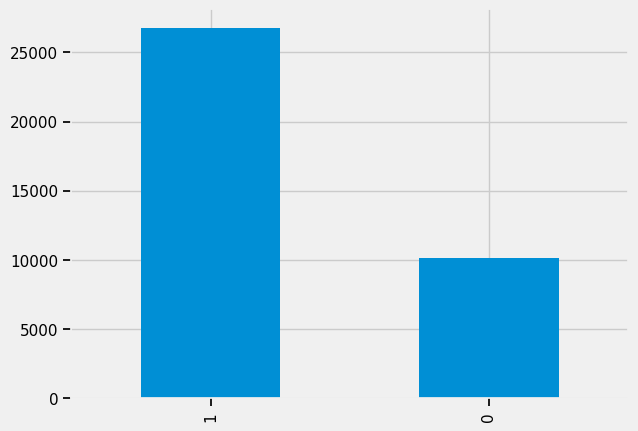

In [ ]:
#Thống kê khoản vay có hoàn trả không
  #0 Khoản vay không được hoàn trả đầy đủ
  #1 Khoản vay được hoàn trả đầy đủ

print(df_loan["not_fully_paid"].value_counts())
df_loan["not_fully_paid"].value_counts().plot(kind="bar")

#Imbalanced data -> xử lý sau trước khi train

#Pre_prosessing data







In [ ]:
#Tìm các field là Object/String -> Chỉ có cột Purpose -> Xử lý cột bằng OneHot
object_cols = [f for f in df_loan.columns if df_loan[f].dtype == "O"]
print(object_cols)


['purpose']


In [ ]:
df_loan["purpose"].value_counts()

debt_consolidation    19516
credit_card            9087
home_improvement       2836
other                  2496
major_purchase          899
medical                 465
house                   406
car                     384
vacation                313
small_business          269
moving                  234
renewable_energy         15
Name: purpose, dtype: int64

In [ ]:
#Nếu cột debt_consolidation = x thì là 1 else tất cả quy về 0
def process_purpose(x):
  if "debt_consolidation" == x:
    return 1
  else:
    return 0
df_loan["purpose_int"] = df_loan["purpose"].apply(process_purpose)

In [ ]:
df_loan["purpose_int"].value_counts()

1    19516
0    17404
Name: purpose_int, dtype: int64

In [ ]:
#Drop cột purpose và view lại
df_loan.drop(columns=["purpose"], inplace=True)
df_loan.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
0,1,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0,0
1,1,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0,0
2,1,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0,0
3,1,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0,0
4,1,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1,1


In [ ]:
#Kiểm tra cột credit_policy
df_loan["credit_policy"].value_counts()

1    36920
Name: credit_policy, dtype: int64

In [ ]:
#Drop cột credit_policy và view lại
df_loan.drop(columns=["credit_policy"], inplace=True)
df_loan.head()

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
0,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0,0
1,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0,0
2,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0,0
3,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0,0
4,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1,1


In [ ]:
#Check corr để xem có bỏ field nào đi không -> Ko thấy 2 cột input nào quá corr -> Giữ lại toàn bộ input
#Ô đậm là ô có corr, corr không quá cao nếu 0,7 0,8 thì bắt đầu xử lý drop
corr = df_loan.corr()
#Lệnh in ra bảng
corr.style.background_gradient(cmap="coolwarm")

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
int_rate,1.000000,0.042739,-0.055919,0.116065,-0.456244,0.086726,0.021824,0.133468,-0.003504,0.172759,0.046075,-0.036599,0.097478
installment,0.042739,1.000000,0.227242,0.084286,0.022387,-0.125390,0.170643,0.028539,0.226005,0.046695,-0.049956,-0.013016,0.140044
log_annual_inc,-0.055919,0.227242,1.000000,-0.121779,0.020853,-0.119594,0.151355,0.044720,0.177392,0.029868,-0.034424,-0.037026,-0.002927
dti,0.116065,0.084286,-0.121779,1.000000,-0.013244,-0.044598,0.077765,0.000342,0.081434,0.032497,-0.010775,-0.031361,0.054696
fico,-0.456244,0.022387,0.020853,-0.013244,1.000000,-0.120728,-0.021722,-0.188516,-0.065700,-0.307689,-0.191167,-0.027124,-0.024893
days_with_cr_line,0.086726,-0.125390,-0.119594,-0.044598,-0.120728,1.000000,-0.066180,-0.068710,-0.187349,-0.052515,-0.006409,-0.038029,-0.006357
revol_bal,0.021824,0.170643,0.151355,0.077765,-0.021722,-0.066180,1.000000,0.128898,-0.203446,-0.146972,-0.067585,-0.356469,0.029699
revol_util,0.133468,0.028539,0.044720,0.000342,-0.188516,-0.068710,0.128898,1.000000,-0.061745,-0.014098,-0.052424,-0.086816,0.004182
inq_last_6mths,-0.003504,0.226005,0.177392,0.081434,-0.065700,-0.187349,-0.203446,-0.061745,1.000000,0.220876,-0.056046,0.219629,-0.007000
delinq_2yrs,0.172759,0.046695,0.029868,0.032497,-0.307689,-0.052515,-0.146972,-0.014098,0.220876,1.000000,-0.030163,0.135084,0.007397


<ipython-input-29-bce98f700674>:11: RuntimeWarning: divide by zero encountered in log10
  scores = -np.log10(selector.pvalues_)


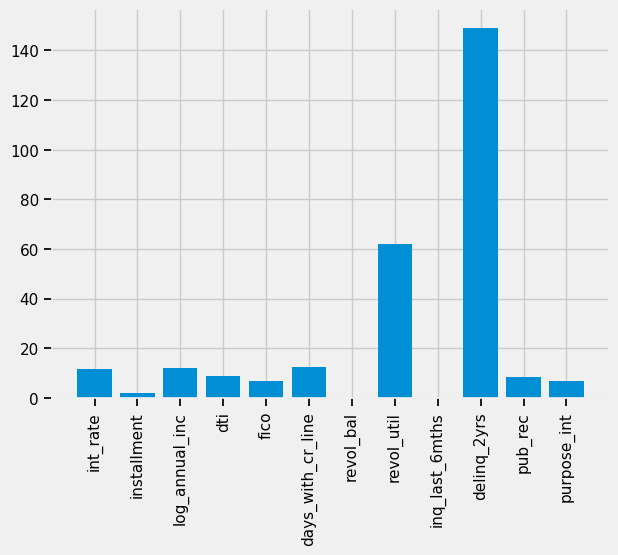

In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = df_loan.drop(columns=["not_fully_paid"]).columns.values

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(df_loan[predictors], df_loan["not_fully_paid"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Có quyền chọn K features tốt nhất. Mình bỏ đi installment, revol_bal và inq_last_6MONTHS


In [ ]:
#Scale dữ liệu

input_fields = df_loan.drop(columns=["not_fully_paid"]).columns.values

X = df_loan[input_fields]
y = df_loan["not_fully_paid"]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X[input_fields])
X[input_fields] = scaler.transform(X[input_fields])

<ipython-input-16-bbaa0fb28693>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[input_fields] = scaler.transform(X[input_fields])


In [ ]:
X.head()

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_int
0,0.352941,0.285030,0.016129,0.015716,0.161290,0.760027,0.039118,0.029304,0.000005,0.333333,0.0,0.0
1,0.223529,0.511634,0.005914,0.030160,0.376344,0.666667,0.023568,0.020696,0.000003,0.066667,0.0,0.0
2,0.137255,0.459866,0.017742,0.016126,0.161290,0.687403,0.040966,0.024652,0.000000,0.000000,0.0,0.0
3,0.458824,0.155066,0.004301,0.032102,0.430108,0.877044,0.016865,0.009826,0.000003,0.000000,0.0,0.0
4,0.137255,0.329176,0.003871,0.023754,0.268817,0.794100,0.014965,0.011130,0.000002,0.000000,0.0,1.0


In [ ]:
#Split dữ liệu train, test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train model 01-Dùng Logitics Regresion, Upsampling bằng SMOTE


In [ ]:
y_train.value_counts()

1    21484
0     8052
Name: not_fully_paid, dtype: int64

In [ ]:
#Upsampling
sm = SMOTE(k_neighbors = 5)
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

In [ ]:
y_train_resample.value_counts()

1    21484
0    21484
Name: not_fully_paid, dtype: int64

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2093
           1       0.87      0.87      0.87      5291

    accuracy                           0.82      7384
   macro avg       0.78      0.78      0.78      7384
weighted avg       0.82      0.82      0.82      7384



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


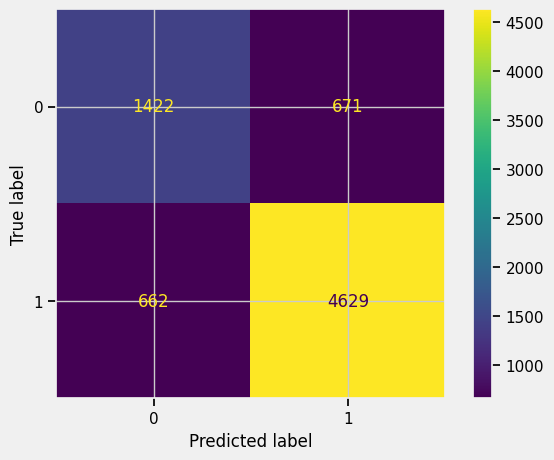

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


#Logitic Regression
model_log = LogisticRegression()
model_log.fit(X_train_resample, y_train_resample)
y_pred = model_log.predict(X_test)

#In ra dữ liệu
print(classification_report(y_test, y_pred))

# Tạo và in ra confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log.classes_)
disp.plot()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search tìm tham số
params_grid_logistic={"C":[0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1", "l2"]}# l1 lasso l2 ridge

grid_logistic= GridSearchCV( LogisticRegression(solver='lbfgs', max_iter=1000) ,params_grid_logistic, cv=10)
grid_logistic.fit(X_train_resample, y_train_resample)

print("tuned hpyerparameters :(best parameters) ",grid_logistic.best_params_)
print('\033[1m' + "accuracy :",grid_logistic.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

tuned hpyerparameters :(best parameters)  {'C': 1000, 'penalty': 'l2'}
accuracy : 0.7933117557656829


              precision    recall  f1-score   support

           0       0.73      0.66      0.69      2093
           1       0.87      0.90      0.89      5291

    accuracy                           0.83      7384
   macro avg       0.80      0.78      0.79      7384
weighted avg       0.83      0.83      0.83      7384



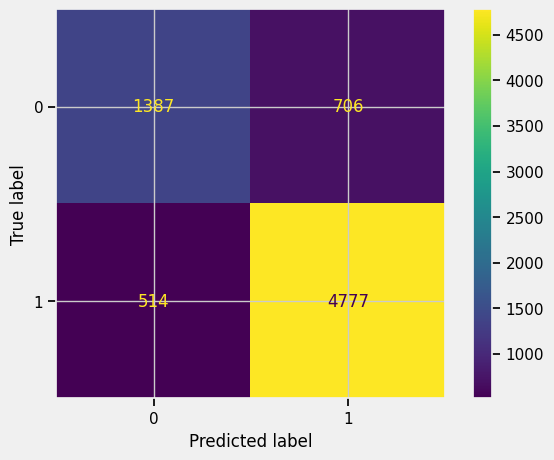

In [ ]:
y_pred = grid_logistic.predict(X_test);
# In ra du lieu
print(classification_report( y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log.classes_)
disp.plot()

#Train 2. Không upsampling. XGBoost


              precision    recall  f1-score   support

           0       0.74      0.65      0.69      2093
           1       0.87      0.91      0.89      5291

    accuracy                           0.84      7384
   macro avg       0.80      0.78      0.79      7384
weighted avg       0.83      0.84      0.83      7384



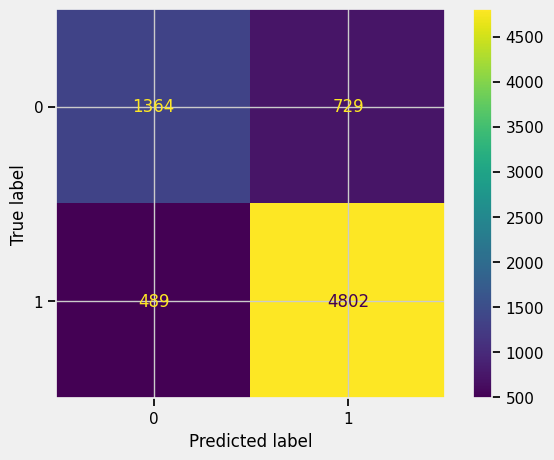

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

# In bao cao ket qua
print(classification_report( y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log.classes_)
disp.plot()

0.77964


<ipython-input-26-0032ea0593ef>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'r--', color="navy")


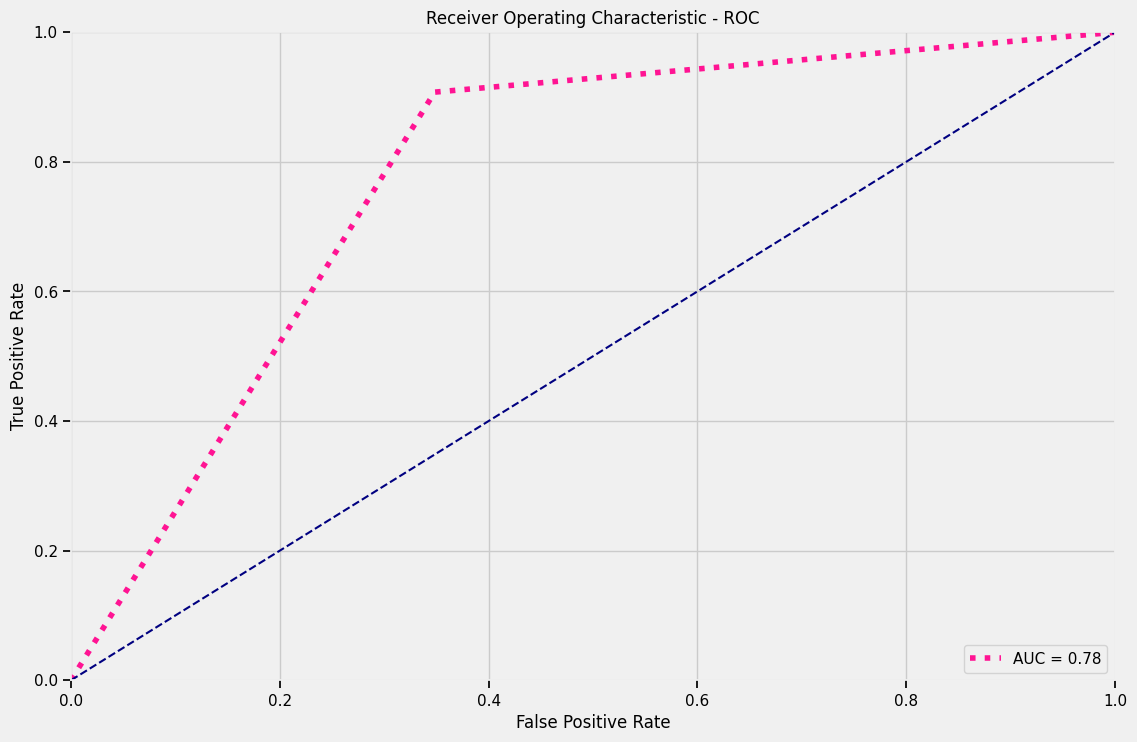

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict

fpr_log_ros, tpr_log_ros, thresholds_log_ros = roc_curve(y_test, y_pred)

auc_log_ros = float("{:.5f}".format(auc(fpr_log_ros, tpr_log_ros)))
print(auc_log_ros)

plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic - ROC')
plt.plot(fpr_log_ros, tpr_log_ros, ':', linewidth=4, label = 'AUC = %0.2f' % auc_log_ros, color="deeppink", )
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color="navy")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Grid search XGBoost
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(60, 220, 100),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_



Fitting 10 folds for each of 24 candidates, totalling 240 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=160, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)